## Домашнее задание 1
* Написать на PyTorch forward & backward полносвязного слоя без использования autograd
* Написать один-два адаптивных оптимизатора
* Решить задачу нахождения корней квадратного уравнения методом градиентного спуска

In [385]:
# Task 1
# Find the roots of square equation by gradient descent
# x ** 2 - 6 * x + 4 = 0

#https://towardsdatascience.com/polynomial-regression-gradient-descent-from-scratch-279db2936fe9
#https://habr.com/ru/post/474602/


# возвести в квадрат
# посчитать производную
# надо начать движение от начальной точки в направлении антиградиента с заданным шагом
# x = x - lr * grad(x)
# всегда ли сойдемся за приемлемое количество шагов?
# важна ли начальная точка?
# как найти второй корень?
# как вляет ЛР?

In [386]:
from sympy import symbols,Eq, solve, diff, Function, Poly, degree
from sympy.plotting import plot

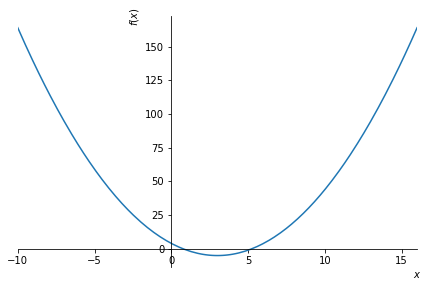

Poly(x**2 - 6*x + 4, x, domain='ZZ')

In [387]:
x,y = symbols('x y')
p = Poly(x**2-6*x+4)

plot(p.as_expr(), (x, -10, 16),xlim=(-10,16))
p

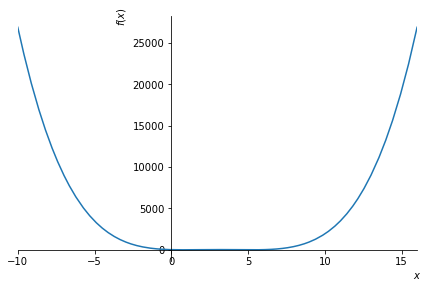

Poly(x**4 - 12*x**3 + 44*x**2 - 48*x + 16, x, domain='ZZ')

In [388]:
p_2= p**2
plot(p_2.as_expr(), (x, -10, 16),xlim=(-10,16))
p_2

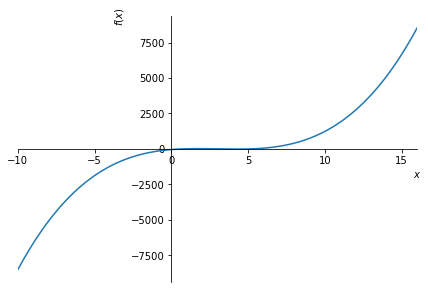

Poly(4*x**3 - 36*x**2 + 88*x - 48, x, domain='ZZ')

In [389]:
p_dff = diff(p_2)
plot(p_dff.as_expr(), (x, -10, 16),xlim=(-10,16))
p_dff

In [390]:
 # задаю learning rate
stop = False

In [391]:
#main loop of root search
lr = 0.0001
start_x = 10.0
iteration_count = 0
while iteration_count<10000:
    x_for_poly_p2 =  start_x - lr * p_dff.eval(x=start_x)
    y_for_p2 = p_2.eval(x=x_for_poly_p2)
    # print(f'Trying x value :{x_for_poly_p2}, got y: {y_for_p2}')
    if 0==y_for_p2:
        print(f'Found root of the equation: {x_for_poly_p2}, steps: {iteration_count}')
        break
    iteration_count+=1
    start_x = x_for_poly_p2

Found root of the equation: 5.23606803730052, steps: 4148


In [392]:
lr = 0.0001
start_x = -10.0
iteration_count = 0
while iteration_count<10000:
    x_for_poly_p2 =  start_x - lr * p_dff.eval(x=start_x)
    y_for_p2 = p_2.eval(x=x_for_poly_p2)
    # print(f'Trying x value :{x_for_poly_p2}, got y: {y_for_p2}')
    if 0==y_for_p2:
        print(f'Found root of the equation: {x_for_poly_p2}, steps: {iteration_count}')
        break
    iteration_count+=1
    start_x = x_for_poly_p2

Found root of the equation: 0.763932008519135, steps: 4529


Task 2
Realize forward and backward pass for linear layer with sigmoid activation

In [393]:
import torch
import numpy as np

In [394]:
def sigmoid(x):
    return 1. / (1 + torch.exp(-x))

def sigmoid_backward(da, x):
    sig = sigmoid(x)
    
    return da * sig * (1 - sig)

def relu(x):
    return torch.tensor(torch.maximum(torch.tensor(0.), x))

def relu_backward(da, x):
    da = da.clone().detach()
    da[x <= 0] = 0;
    return da;

In [395]:
def mse_loss(t, y):
    return (t - y) ** 2

def d_mse_loss(t, y):
    return 2 * (y - t) 

In [396]:
class LinearLayer:
    def __init__(self, n_inp, n_out, activation='sigmoid'):
        self.w = torch.randn(n_out, n_inp) * 0.1
        self.b = torch.randn(n_out, 1) * 0.1
        if activation == 'sigmoid':
            self.activ = sigmoid
        if activation == 'relu':
            self.activ = relu
        elif activation == 'None':
            self.activ = None
        else:
            raise Exception(f'Unknown activation "{activation}"')
        self._clear_state()

    def _clear_state(self):
        self.lin = None
        self.inp = None
        self.d_w = None
        self.d_b = None

    def forward(self, x):
        self.inp = x
        self.lin = torch.mm(self.w, x.float()) + self.b
        activ = self.activ(self.lin) if self.activ is not None else self.lin
        return activ

    def backward(self, grad): # grad = d L / d z    Dout 
        # grad * dz / d lin
        if self.activ == sigmoid:
            grad_lin = sigmoid_backward(grad, self.lin) 
        elif self.activ == relu:
            grad_lin = relu_backward(grad, self.lin)
        else:
            grad_lin = grad
        # grad_lin * d lin / d w 
        m = self.inp.shape[1]
        self.d_w = torch.mm(grad_lin, self.inp.T.float()) / m    # d_in dOut
        # grad_lin * d lin / d b 
        self.d_b = torch.sum(grad_lin, axis=1, keepdims=True) / m

        grad = torch.mm(self.w.T, grad_lin)

        return grad

# pred = model(x)
# loss = criterion(pred, target)
# grad = d loss / d pred
# model.backward(grad)

In [397]:
from typing import Tuple

class Model:
    def __init__(self, arch: Tuple[Tuple[int, int]], activation):
        self.layers = []
        for i, p in enumerate(arch):
            self.layers.append(
                LinearLayer(p[0], p[1], 
                            activation=activation if i < len(arch)-1 else 'None')
                )
        self._clear_state()
    
    def _clear_state(self):
        for l in self.layers:
            l._clear_state()

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        
        return x

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)

        return grad 

Task 3
Realize SGD Momentum optimizer
velocity = momentum * velocity - lr * gradient
w = w + velocity

In [398]:
#для одного слоя
class SGDMomentum:
    def __init__(self, model: LinearLayer, lr=0.001, momentum=0.99):
        self.lr = lr
        self.m = momentum
        self.model = model

        self.vel_w = torch.zeros_like(model.w)
        self.vel_b = torch.zeros_like(model.b)

    def step(self):
        self.vel_w = self.m * self.vel_w - self.lr * self.model.d_w
        self.vel_b = self.m * self.vel_b - self.lr * self.model.d_b

        self.model.w += self.vel_w
        self.model.b += self.vel_b

        


In [399]:
#для всей модели
class SGDMomentum:
    def __init__(self, model: Model, lr= 0.0001, momentum=0.0):
        self.model = model
        self.lr = lr
        self.m = momentum
        self.vel = [[torch.zeros_like(layer.w), 
                     torch.zeros_like(layer.b)] for layer in model.layers]

    def step(self):
        for i, layer in enumerate(self.model.layers):
            self.vel[i][0] = self.vel[i][0] * self.m - self.lr * layer.d_w 
            self.vel[i][1] = self.vel[i][1] * self.m - self.lr * layer.d_b 
            layer.w += self.vel[i][0]
            layer.b += self.vel[i][1]
    
    def zero_grad(self):
        self.model._clear_state()

In [400]:
x = np.random.uniform(-2, 2, 20000)
#x = torch.distributions.Uniform(-2,2,2000)
y = x**2 + np.random.randn()*0.1

In [401]:
model = Model(((1, 100), (100, 1)), activation='relu')
optim = SGDMomentum(model)
for e in range(20):
    for i, (val, t) in enumerate(zip(x, y)):
        optim.zero_grad()
        pred = model.forward(torch.tensor([[val]]))
        loss = mse_loss(t, pred)
        grad = d_mse_loss(t, pred)
        model.backward(grad)
        optim.step()
        
    print(e, model.forward(torch.tensor([[1]])), model.forward(torch.tensor([[2]])), model.forward(torch.tensor([[-1]])), model.forward(torch.tensor([[-2]])))

/var/folders/52/g94rqcwd0r55zsr1ccm405300000gp/T/ipykernel_10349/1364784206.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.maximum(torch.tensor(0.), x))


0 tensor([[1.5347]]) tensor([[2.6667]]) tensor([[1.5181]]) tensor([[2.7964]])
1 tensor([[1.4714]]) tensor([[3.1924]]) tensor([[1.4420]]) tensor([[3.2969]])
2 tensor([[1.4218]]) tensor([[3.3877]]) tensor([[1.3934]]) tensor([[3.4700]])
3 tensor([[1.3883]]) tensor([[3.4715]]) tensor([[1.3659]]) tensor([[3.5351]])
4 tensor([[1.3587]]) tensor([[3.5221]]) tensor([[1.3428]]) tensor([[3.5692]])
5 tensor([[1.3293]]) tensor([[3.5636]]) tensor([[1.3196]]) tensor([[3.5979]])
6 tensor([[1.2995]]) tensor([[3.6020]]) tensor([[1.2952]]) tensor([[3.6263]])
7 tensor([[1.2699]]) tensor([[3.6375]]) tensor([[1.2704]]) tensor([[3.6545]])
8 tensor([[1.2414]]) tensor([[3.6700]]) tensor([[1.2458]]) tensor([[3.6814]])
9 tensor([[1.2145]]) tensor([[3.6995]]) tensor([[1.2219]]) tensor([[3.7064]])
10 tensor([[1.1892]]) tensor([[3.7257]]) tensor([[1.1990]]) tensor([[3.7294]])
11 tensor([[1.1656]]) tensor([[3.7490]]) tensor([[1.1773]]) tensor([[3.7504]])
12 tensor([[1.1437]]) tensor([[3.7696]]) tensor([[1.1605]]) te